Para hacer apply a un daskdataframe es necesario pasarle meta que es el tipo de datos que va a tener. https://stackoverflow.com/a/44437675

In [2]:
import pandas as pd
import numpy as np
import glob
import os
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
# import dask.dataframe as dd # en caso de tener muchos datos
import locale
import re
locale.setlocale(locale.LC_TIME, "es_ES") 

'es_ES'

# Unión de los CSV

In [ ]:
files = glob.glob("datos/Coches_Cuadro_Oferta_Real/*/Coches_Cuadro_Oferta_Real_*.csv")
# Read column names from file
cols = list(pd.read_csv(files[0], sep=';',nrows=1))
cols = list(filter(lambda col: col.strip(), cols))


#Cargamos los datos y especificamos los tipos en las columnas, así como eliminar la última columna por ser vacia
dfs = [pd.read_csv(f, header=0, sep=";",encoding = "ISO-8859-1",dtype={'Elinea':'str'},usecols=cols) for f in files]
df = pd.concat(dfs,ignore_index=True)


# Elimnar el último dataframe del último fichero de la memoria
del dfs

df.to_csv('datos/Coches_Cuadro_Oferta_Real/autobuses_oferta_real.csv')

# Análisis

In [15]:
oferta = pd.read_csv('datos/Coches_Cuadro_Oferta_Real/autobuses_oferta_real.csv',dtype={'Elinea':'str'})
oferta.drop(columns='Unnamed: 0',inplace=True)


1. Ponemos la columna `FServicio` en formato fecha
2. Creamos una nueva columna para saber si esa fecha era un día de lunes a viernes (True) o sábado y domingo (False)
3. Completamos la columna `Coches` con 0 si no tienen valor.



In [ ]:
oferta['FServicio'] = pd.to_datetime(oferta['FServicio'], format='%d/%m/%Y')
oferta.loc[oferta['FServicio'].dt.dayofweek > 4,'Diario'] = False
oferta['Diario'].fillna(True,inplace=True)
oferta['Coches'].fillna(0,inplace=True)

Creamos una tabla auxiliar para crear una nueva columna `fechaCorta` que tendrá el mes y año de `FServicio` y la unimos con el conjunto de datos que estamos usando `oferta`

In [16]:
tiempos = pd.DataFrame({'FServicio': pd.date_range('2019-01-01', '2021-12-31', freq='D')})
tiempos['fechaCorta'] = tiempos['FServicio'].dt.strftime('%B.%Y')
if 'fechaCorta' not in oferta.columns:
    oferta = oferta.join(tiempos.set_index('FServicio'),on='FServicio')
    
oferta.head()

,CLinea,Elinea,Denominacion,FServicio,IDFranja,Intervalo,Coches,Diario,fechaCorta
0,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-01,H07,070000 - 075959,2.0,True,enero.2019
1,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-01,H08,080000 - 085959,3.0,True,enero.2019
2,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-01,H09,090000 - 095959,3.0,True,enero.2019
3,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-01,H10,100000 - 105959,4.0,True,enero.2019
4,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-01,H11,110000 - 115959,4.0,True,enero.2019


In [19]:
# https://stackoverflow.com/questions/38869778/pandas-set-column-equal-to-grouped-sum-of-another-column?noredirect=1&lq=1

oferta['MediaCochesMes'] = oferta.groupby(by=['CLinea', 'fechaCorta', 'IDFranja']).Coches.transform('mean')

,CLinea,Elinea,Denominacion,FServicio,IDFranja,Intervalo,Coches,Diario,fechaCorta,MediaCochesMes
0,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-01,H07,070000 - 075959,2.0,True,enero.2019,5.580645
1,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-01,H08,080000 - 085959,3.0,True,enero.2019,6.580645
2,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-01,H09,090000 - 095959,3.0,True,enero.2019,7.387097
3,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-01,H10,100000 - 105959,4.0,True,enero.2019,8.903226
4,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-01,H11,110000 - 115959,4.0,True,enero.2019,9.193548
...,...,...,...,...,...,...,...,...,...,...
3866431,781,SE,ATOCHA - NUEVOS MINISTERIOS,2021-08-29,H20,200000 - 205959,5.0,False,agosto.2021,7.758621
3866432,781,SE,ATOCHA - NUEVOS MINISTERIOS,2021-08-29,H21,210000 - 215959,5.0,False,agosto.2021,7.068966
3866433,781,SE,ATOCHA - NUEVOS MINISTERIOS,2021-08-29,H22,220000 - 225959,5.0,False,agosto.2021,6.379310
3866434,781,SE,ATOCHA - NUEVOS MINISTERIOS,2021-08-29,H23,230000 - 235959,5.0,False,agosto.2021,5.000000


In [23]:
# Nuevo dataframe con sólo los días que sean lunes a viernes
entresemana = oferta[oferta['Diario']==True].copy()
entresemana['MediaCochesLaborables'] = entresemana.groupby(by=['CLinea', 'fechaCorta', 'IDFranja']).Coches.transform('mean')

In [24]:
oferta_mes = entresemana.drop_duplicates(['CLinea','fechaCorta','IDFranja']).reset_index(drop=True)
oferta_mes.head()

,CLinea,Elinea,Denominacion,FServicio,IDFranja,Intervalo,Coches,Diario,fechaCorta,MediaCochesMes,MediaCochesLaborables
0,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-01,H07,070000 - 075959,2.0,True,enero.2019,5.580645,6.478261
1,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-01,H08,080000 - 085959,3.0,True,enero.2019,6.580645,7.478261
2,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-01,H09,090000 - 095959,3.0,True,enero.2019,7.387097,8.391304
3,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-01,H10,100000 - 105959,4.0,True,enero.2019,8.903226,10.260870
4,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-01,H11,110000 - 115959,4.0,True,enero.2019,9.193548,10.304348


Con estas últimas operaciones hemos extendido a todas las filas que sean del mes M y del año A su valor de MediaCochesMes y MediaCochesLaborables.

In [26]:
entresemana[\
    (entresemana['IDFranja']=='H07')\
    &(entresemana['CLinea']==1)\
    &(entresemana['FServicio'].dt.year==2019)\
    &(entresemana['FServicio'].dt.month==1)\
    ].head()

,CLinea,Elinea,Denominacion,FServicio,IDFranja,Intervalo,Coches,Diario,fechaCorta,MediaCochesMes,MediaCochesLaborables
0,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-01,H07,070000 - 075959,2.0,True,enero.2019,5.580645,6.478261
19,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-02,H07,070000 - 075959,6.0,True,enero.2019,5.580645,6.478261
38,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-03,H07,070000 - 075959,6.0,True,enero.2019,5.580645,6.478261
57,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-04,H07,070000 - 075959,6.0,True,enero.2019,5.580645,6.478261
112,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-07,H07,070000 - 075959,3.0,True,enero.2019,5.580645,6.478261


In [56]:
#Función para gráficar con matplotlib la línea en la fronja que corresponda

def graficar(dataset,num_linea,franja,media='MediaCochesMes',guardar=False):
    fig, axes = plt.subplots(figsize=(12, 5),dpi=100)
    axes.spines.right.set_visible(False)
    axes.spines.top.set_visible(False)

    # num_linea = 21
    # franja = 'H10'

    # Filtro por linea y franja
    data = dataset[(dataset['IDFranja']==franja)&(dataset['CLinea']==num_linea)].reset_index(drop=True)
    if len(data)==0:
        listado_franjas = dataset.loc[dataset['CLinea']==num_linea,'IDFranja'].unique()
        raise Exception(f"Las franjas horarias de la linea {num_linea} son: {listado_franjas}") 
        
    lineaPublico = str(data.loc[0,"Elinea"])
    cartel_linea = str(data.loc[0,"Denominacion"])

    # Visualizo los datos (avg_coches) y fechas
    for fecha in data['FServicio'].dt.year.unique():
        axes.plot(data.loc[data['FServicio'].dt.year == fecha,'fechaCorta'],data.loc[data['FServicio'].dt.year == fecha, media],'-o',label='Franja: '+ franja +'\nAño: '+str(fecha))


    # Configuraciones visuales
    axes.set_xticks(data['fechaCorta'])
    axes.set_xticklabels(data['fechaCorta'], rotation = 45, ha="right",fontdict=dict({'color': 'grey'}))
    axes.set_ylim([0,data['Coches'].max()+3])

    xTicks = axes.get_xticklabels()
    indices_enero = [i for i, item in enumerate(data.fechaCorta) if re.search('enero|January', item)]
    for indeceEnero in indices_enero:
        xTicks[indeceEnero].set_color('black')
        # axes.vlines(x=indeceEnero,ymin=0,ymax=axes.get_yticks().max(),colors='black',linestyles='dashed',)

    # Título y nombre ejes
    axes.set_xlabel('fecha')
    axes.set_ylabel('Media_NumeroDeBus')
    axes.set_title(label=f'Evolución núm. autobuses ({media})\nLÍNEA {lineaPublico}: {cartel_linea}',pad=20)
    # axes.set(
    #     xlabel='Mes',
    #     ylabel='Media_NumeroDeBus',
    #     title=f'Evolución núm. autobuses (media)\nLÍNEA {num_linea}: {cartel_linea}'
    #     )
    axes.grid(color="#172a3d", linestyle='--', linewidth=1, axis='both', alpha=0.15)
    leg = axes.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0)


    plt.draw()

    # FALTA POR HACER ESTO-> Poner una caja debajo de las leyedenas que muestren datos como máx y min
    # p = leg.get_window_extent()
    # print(p)
    # axes.annotate('Annotation Text', (p.p0[0], p.p1[1]+10), (p.p0[0], p.p1[1]), 
    #             xycoords='figure pixels', zorder=9)


    # plt.legend(loc="lower right") # Esto puede deshabilitar quitando la línea
    if guardar:
        plt.savefig(fname=f'images/LÍNEA_{num_linea}_{franja}_{cartel_linea}.jpg',format='jpg', bbox_inches='tight', dpi=200)

    plt.show()

In [33]:
coches_mes = oferta_mes.loc[:,['CLinea','FServicio','IDFranja','MediaCochesLaborables']].copy()

In [39]:
# Creo una key única que es de la forma `CLinea_IDFranja_NombreMes_Año`
for index in range(0,3):
    coches_mes[f'key_{index}'] = coches_mes['CLinea'].astype(str).str.zfill(3)\
                +'_'+coches_mes['IDFranja']\
                +'_'+coches_mes['FServicio'].dt.month_name()\
                +'_'+ (coches_mes['FServicio'].dt.year-index).astype(str)

In [40]:
# En caso de que ya tenga las columnas las elimino para que no me de problemas
indices = [i for i, item in enumerate(coches_mes.columns) if re.search('avg_key_', item)]
if len(indices)>0:
    coches_mes.drop(coches_mes.columns[indices],axis=1,inplace=True)

 # VLOOKUP EN PYTHON  
for idx in range(1,3):
    coches_mes.insert(len(coches_mes.columns), f'avg_key_{idx}', coches_mes[f'key_{idx}'].map(coches_mes.set_index(f'key_0')['MediaCochesLaborables']))

In [ ]:
coches_mes = coches_mes[sorted(coches_mes.columns)]
coches_mes[coches_mes['CLinea']<310].sort_values(by='avg_key_1',ascending=True)

# POSIBLE IDEA
Para poder comparar las líneas, podemos hacer una media nueva sobre las horas puntas de la mañana (de H07 hasta las H09).

Al reducir a esas franjas horarias, son las franjas horarias de mayor afluencia se Comunidad de Madrid, eliminamos la columna de `IDFranja` y podemos crear un nuevo dataframe más simple de la forma siguiente:

| Línea | AVG_2019 | AVG_2020 | AVG_2021 |
| ----- | -------- | -------- | -------- |
|  25   |    X     |    Y     |     Z    |

Calcular para cada linea y franja horaria la diferencia de autobuses por mes para cada año 

| Línea |   Fecha    | Diff.AñoAnterior |
|-------|   -------  |------------------|
|   1   | enero.2020 |       10%        |
|   1   | enero.2021 |       -5%        |


#### Duda
Si quisiera mirar la línea que mayor diferencia ha tenido (sin tener en consideración la pandemia) me saldría ordenado por franjas horarias, pero no por linea y franja.

# Hora punta Madrid
Según el informe anual de [2018 de CRTM](https://www.crtm.es/media/712934/edm18_sintesis.pdf#page=54) y [Encuesta Sintética de Movilidad - ESM14](https://www.crtm.es/media/519661/esm_2014.pdf) las franjas horarias quedan de la siguiente manera:

- La hora punta de la mañana es la comprendida entre las 08h-09h.
- El periodo valle se produce entra las 10h-13h.
- La hora punta del mediodía es la comprendida entre las 14h-15h.
- La hora punta del mediodía es la comprendida entre las 17h-20h.

_Los viajes por movilidad ocupacional, trabajo y estudios, se producen en dos periodos concretos, entre las 6h y las 9h de la mañana y entre la 13h y las 15 h de la tarde. Existe otro pico entre las 16h y las 18h relacionado con la salida de los centros escolares o el fin de la jornada laboral._


In [46]:
# Esto seguro que puedo dejarlo en un mismo dataframe
diurnas_regulares = oferta_mes[oferta_mes['CLinea']<500]

horapunta = diurnas_regulares[(diurnas_regulares['IDFranja']=='H07')\
                              | (diurnas_regulares['IDFranja']=='H08')\
                              | (diurnas_regulares['IDFranja']=='H09')].copy()

In [47]:
horapunta['MediaCochesHoraPunta'] = horapunta.groupby(by=['CLinea', 'fechaCorta'])['MediaCochesLaborables'].transform('mean')
horapunta.drop_duplicates(['CLinea','fechaCorta'],inplace=True)

In [45]:
horapunta

,CLinea,Elinea,Denominacion,FServicio,IDFranja,Intervalo,Coches,Diario,fechaCorta,MediaCochesMes,MediaCochesLaborables,MediaCochesHoraPunta
0,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-01,H07,070000 - 075959,2.0,True,enero.2019,5.580645,6.478261,7.449275
20,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-02-01,H07,070000 - 075959,7.0,True,febrero.2019,5.857143,7.000000,8.000000
39,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-03-01,H07,070000 - 075959,7.0,True,marzo.2019,5.709677,7.000000,8.000000
58,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-04-01,H07,070000 - 075959,7.0,True,abril.2019,5.500000,6.409091,7.378788
76,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-05-01,H07,070000 - 075959,3.0,True,mayo.2019,6.161290,7.260870,8.217391
...,...,...,...,...,...,...,...,...,...,...,...,...
132356,481,H1,SIERRA DE GUADALUPE - HOSPITAL INFANTA LEONOR,2021-08-02,H07,070000 - 075959,3.0,True,agosto.2021,2.419355,3.000000,3.000000
132374,481,H1,SIERRA DE GUADALUPE - HOSPITAL INFANTA LEONOR,2021-09-01,H07,070000 - 075959,3.0,True,septiembre.2021,2.466667,3.000000,3.636364
132392,481,H1,SIERRA DE GUADALUPE - HOSPITAL INFANTA LEONOR,2021-10-01,H07,070000 - 075959,3.0,True,octubre.2021,2.290323,2.904762,3.539683
132409,481,H1,SIERRA DE GUADALUPE - HOSPITAL INFANTA LEONOR,2021-11-01,H07,070000 - 075959,1.0,True,noviembre.2021,2.333333,2.818182,3.424242


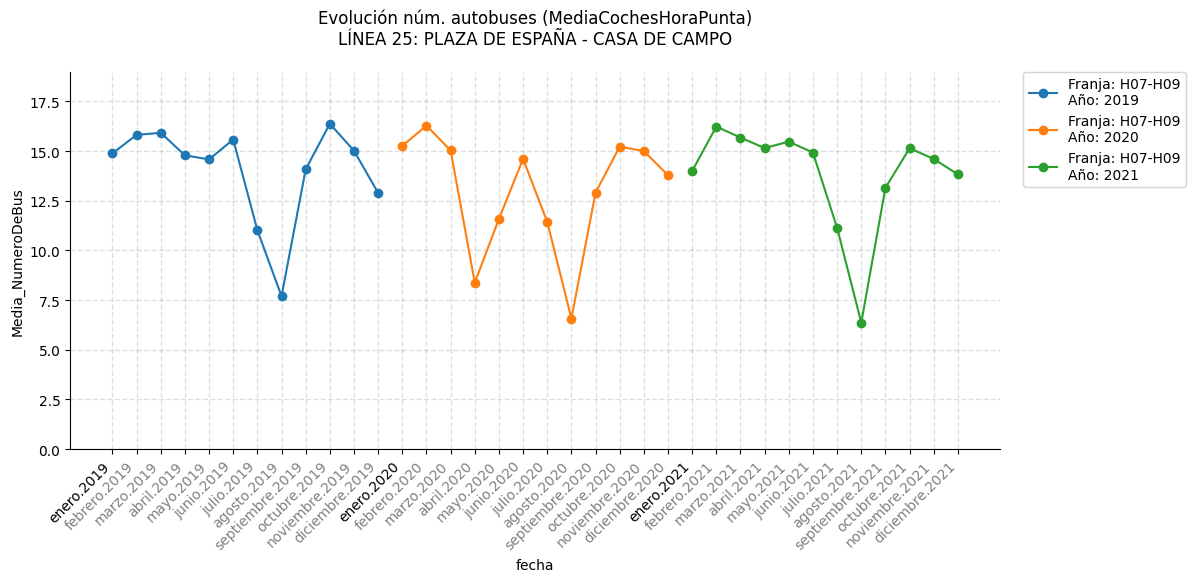

In [58]:
horapunta.reset_index(drop=True,inplace=True)
horapunta['IDFranja'] = 'H07-H09'

graficar(horapunta,num_linea=25,franja='H07-H09',media='MediaCochesHoraPunta')

In [ ]:
####################
# ESTO SON PRUEBAS #
####################

# tmp = media_buses.copy()
# tmp['mes'] = tmp['FServicio'].dt.month
# tmp['year'] = tmp['FServicio'].dt.year
# tmp['key_1'] = tmp['CLinea'].astype(str).str.zfill(3)+tmp['IDFranja']+tmp['mes'].astype(str)+tmp['year'].astype(str)
# tmp['key_2'] = tmp['CLinea'].astype(str).str.zfill(3)+tmp['IDFranja']+tmp['mes'].astype(str)+(tmp['year']-1).astype(str)
# tmp['key_3'] = tmp['CLinea'].astype(str).str.zfill(3)+tmp['IDFranja']+tmp['mes'].astype(str)+(tmp['year']-2).astype(str)
# tmp2 = tmp.loc[:,['key_1','key_2','key_3','FServicio','fechaCorta','CLinea','IDFranja','avg_coches']]

# # https://stackoverflow.com/questions/41511730/python-function-similar-to-vlookup-excel
# if 'avg_key_2' in tmp2.columns:
#     tmp2.drop(columns=['avg_key_2'],inplace=True)
# if 'avg_key_3' in tmp2.columns:
#     tmp2.drop(columns=['avg_key_3'],inplace=True)

# tmp2.insert(len(tmp2.columns), 'avg_key_2', tmp2['key_2'].map(tmp2.set_index('key_1')['avg_coches']))
# tmp2.insert(len(tmp2.columns), 'avg_key_3', tmp2['key_3'].map(tmp2.set_index('key_1')['avg_coches']))
# # tmp2.fillna(0,inplace=True)
# tmp2.reset_index(inplace=True,drop=True)
# tmp2['diff_key1_key2'] = (tmp2['avg_coches']-tmp2['avg_key_2'])
# tmp2['diff_key1_key3'] = (tmp2['avg_coches']-tmp2['avg_key_3'])
# tmp2.sort_values(by='diff_key1_key3')
# tmp3 = tmp2[tmp2['FServicio'].dt.year!=2020].sort_values(by='diff')
# tmp3 = tmp3[tmp3['CLinea']<500]
# tmp3['diff'].fillna(0,inplace=True)
# dff = tmp2.sort_values(by='diff_key1_key3').reset_index(drop=True).loc[0,:]
# graficar(num_linea=dff['CLinea'],franja=dff['IDFranja'])

# Líneas con mayor afluencia de pasajeros
Según este tweet de [@EMTmadrid](https://twitter.com/emtmadrid/status/956855958369701889?lang=es) las líneas con mayor demanda en 2017 son: L34, L27, L70, C1, C2, L31, L28, L35 y L17.

La demanda de estas líneas supone un 26.5% del total, equivalente 113 millones de pasajeros en dicho año.

In [48]:
numero_viajeros = pd.read_csv('datos/Grado_de_Ocupación/numero_viajeros.csv')

In [49]:
ranking = numero_viajeros.iloc[:,:3].copy()

In [50]:
for year in range(2014,int(numero_viajeros.columns[-1])):
    rank = numero_viajeros.loc[:,['Código',str(year)]].sort_values(by=[str(year)], ascending=False)
    rank[str(year)] = rank.reset_index().index+1
    # numero_viajeros[str(year)].sort_values(ascending=False).reset_index().rename(columns={'index':'Código'})
    ranking = ranking.merge(rank)

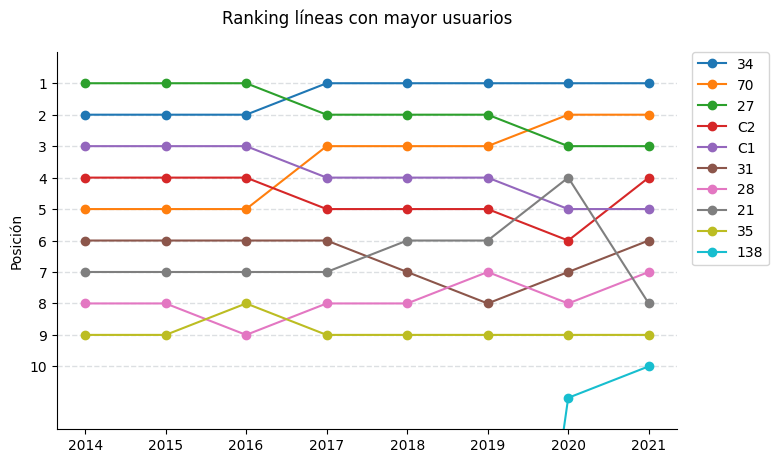

In [51]:
data = ranking.sort_values(by='2021').iloc[0:10,:]

fig, axes = plt.subplots(figsize=(8, 5),dpi=100)
axes.spines.right.set_visible(False)
axes.spines.top.set_visible(False)

# Visualizo los datos (avg_coches) y fechas

years = data.columns[3:]

axes.plot(years,data.iloc[:,3:].T,'-o',label=data["Etiqueta"])

# Título y nombre ejes
# axes.set_xlabel('Años')
axes.set_ylabel('Posición')
axes.set_title(label=f'Ranking líneas con mayor usuarios',pad=20)
   
axes.set_xticks(range(0,len(years)))
axes.set_xticklabels(years)
axes.set_ylim(0,12)
axes.set_yticks(range(1,11))
axes.invert_yaxis()

axes.grid(color="#172a3d", linestyle='--', linewidth=1, axis='y', alpha=0.15)
axes.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0)
plt.show()